# Questions

*   How to make the output of the trasnformer be adataframe?
*   why use  cross_val_score and not cross_validate?



##Loading the Data and EDA

###Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path
%matplotlib inline

###Loading the Data

In [3]:
# File Paths
X_train_Filename = csv_drive_path_generatoer('https://drive.google.com/file/d/1BcNd5fvzY_wSp9RSEp9pgsllko24RZef/view?usp=sharing')#"/content/X_train.csv"
y_train_Filename = csv_drive_path_generatoer('https://drive.google.com/file/d/10FfNimLrCSOQEQlPdf5UlKhXerJ_oYuF/view?usp=sharing')#"/content/y_train.csv"
X_test_Filename  = csv_drive_path_generatoer('https://drive.google.com/file/d/17yXAAn592_UPQNAvWhoQ6mKfpTn-AWf0/view?usp=sharing')#"/content/X_test.csv"

# Load the Train dataset
X_train = pd.read_csv(X_train_Filename)
y_train = pd.read_csv(y_train_Filename)

# Load the Test dataset
X_test = pd.read_csv(X_test_Filename)

# Set 'Unnamed: 0' as the index for X_train and y_train (will be useful later for lines removal)
X_train.set_index('Unnamed: 0', inplace=True)
y_train.set_index('Unnamed: 0', inplace=True)

X_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
Unnamed: 0,,,,,,,,,,
1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,1847,white
2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,2905,white
4610,Bachelors,2015,Pune,3,26.0,Female,No,2,4610,white
2228,Bachelors,2012,Bangalore,3,29.0,Male,No,1,2228,black
5,Bachelors,2016,Bangalore,3,24.0,Male,No,0,5,white


###EDA

Performing EDA for both X_Test and X_Train and compare between them to see if they similar

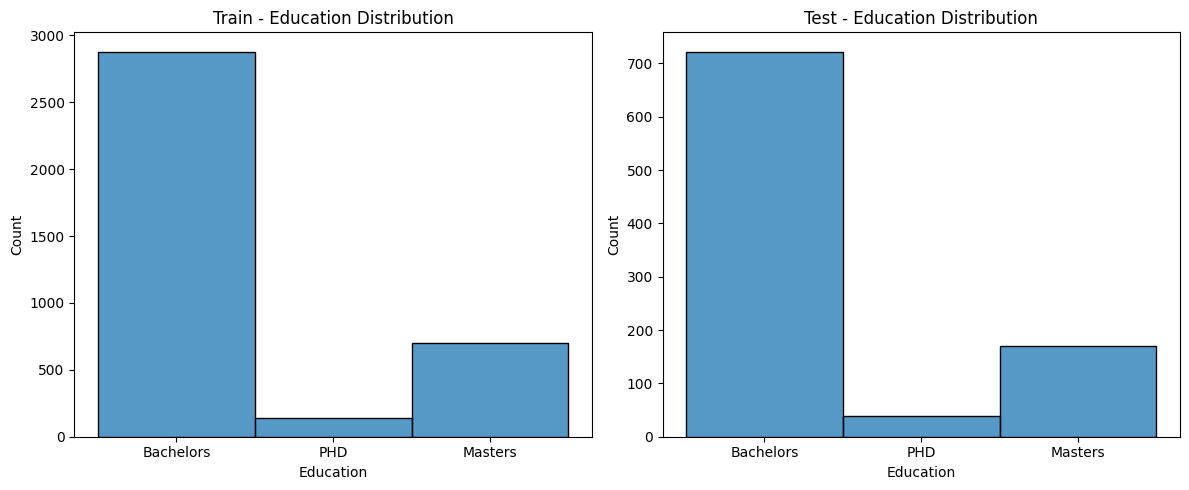

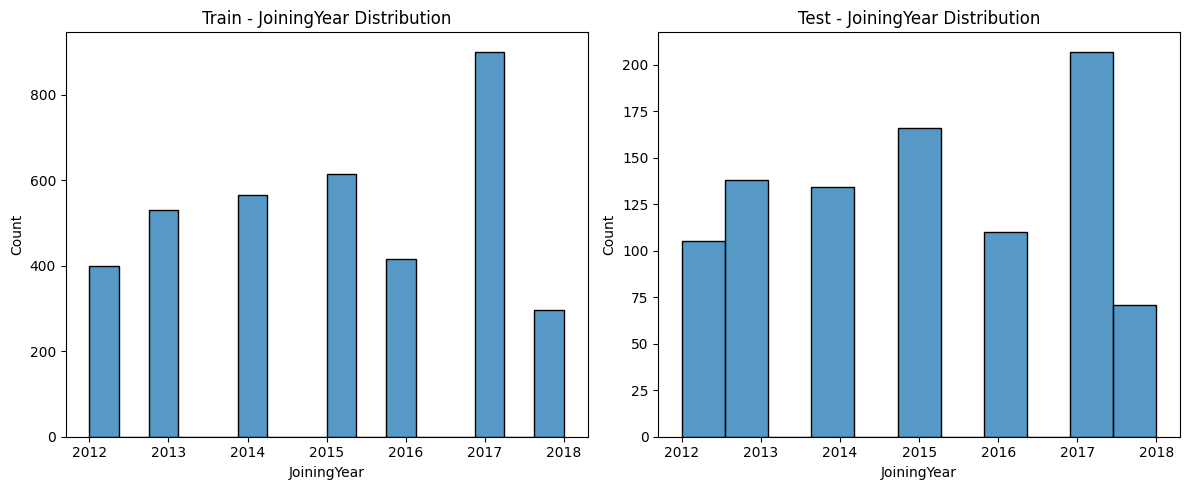

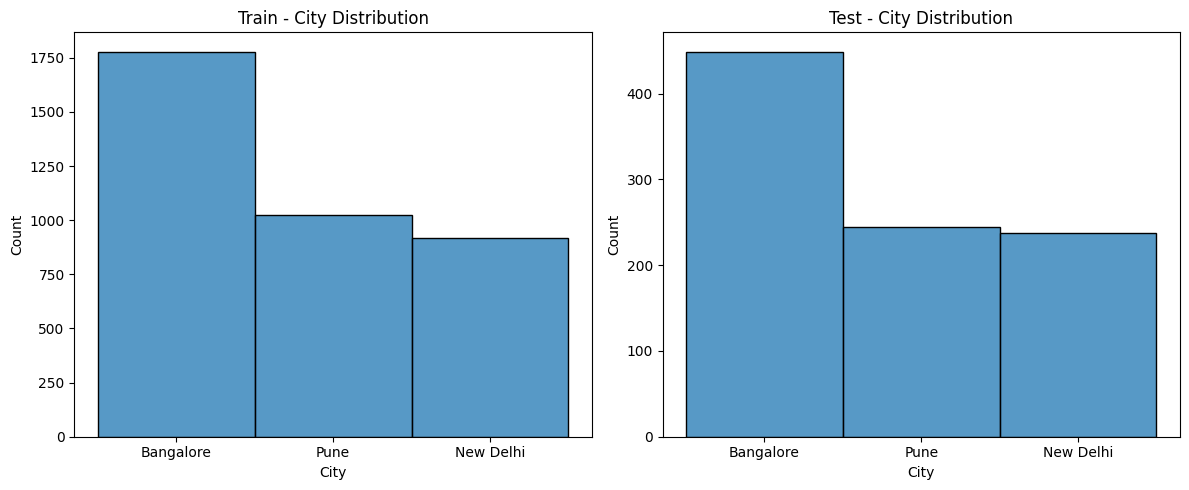

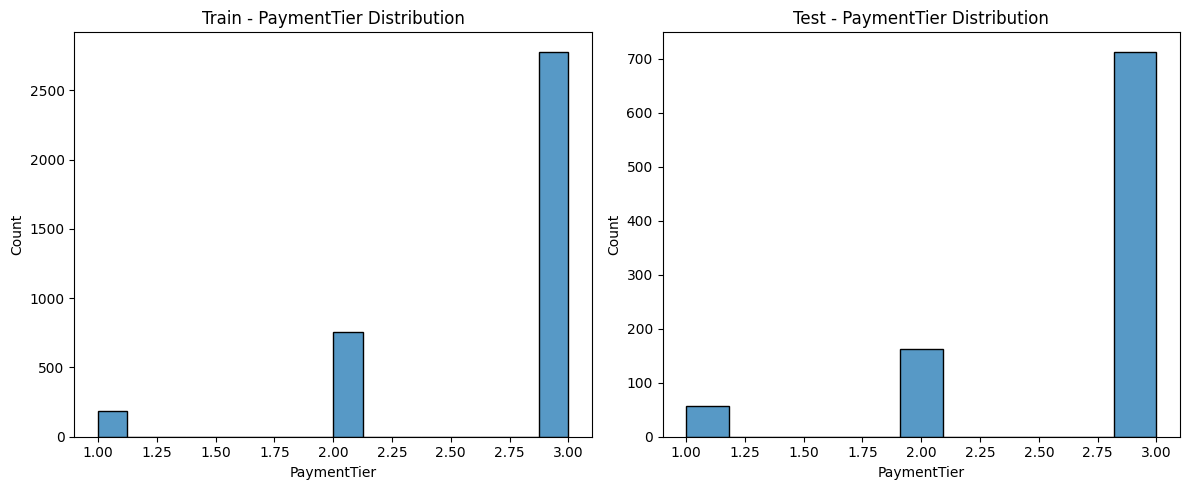

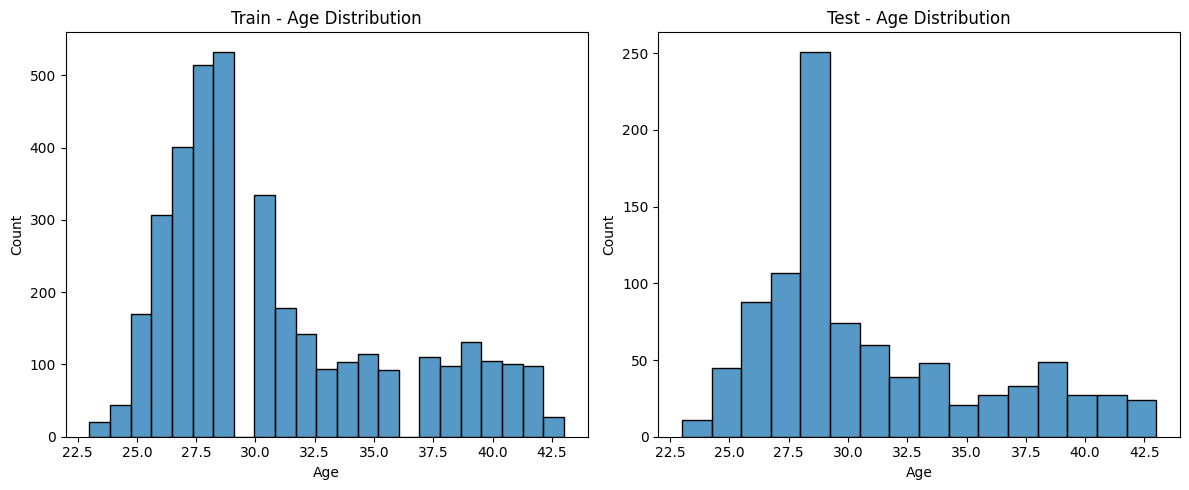

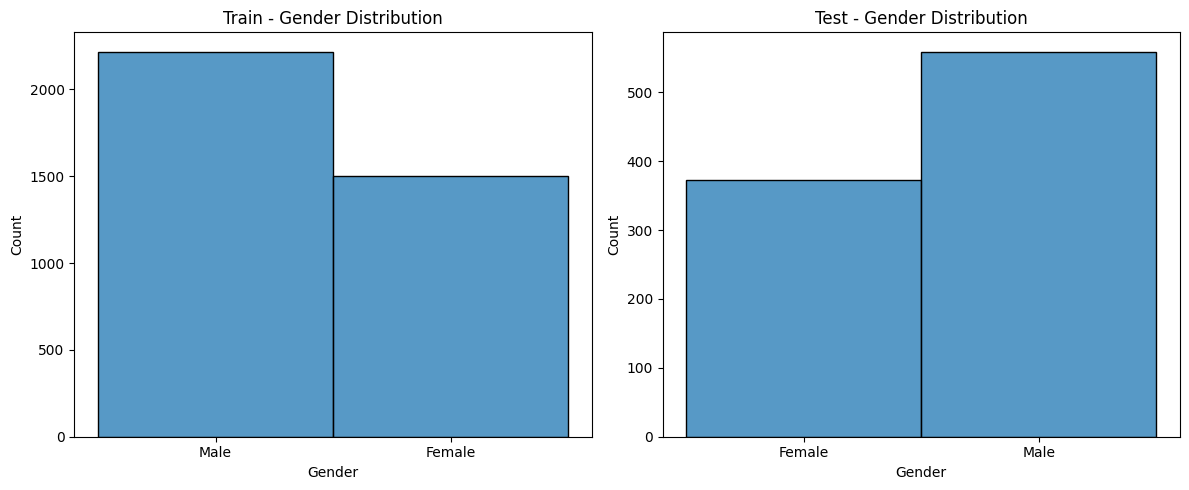

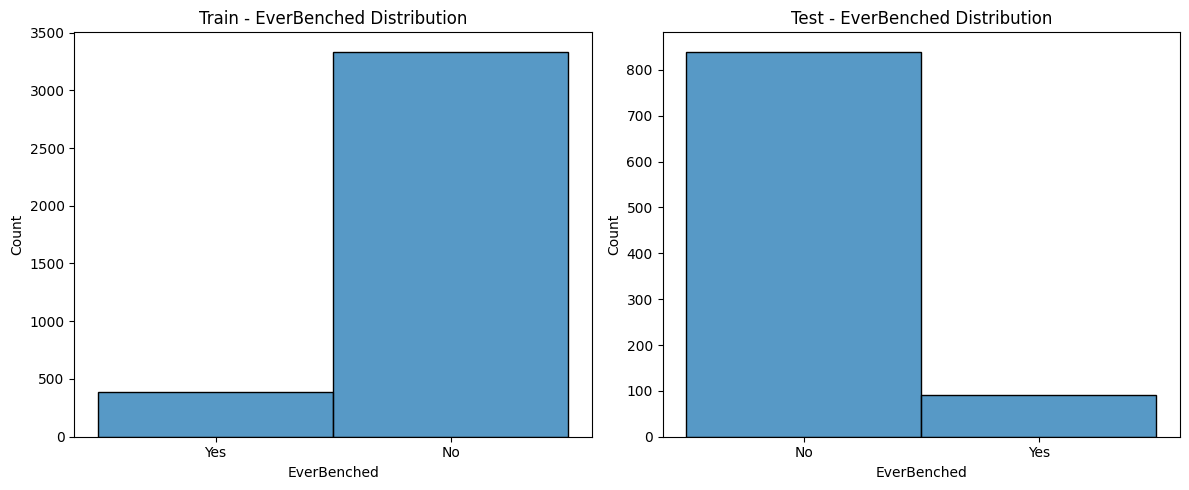

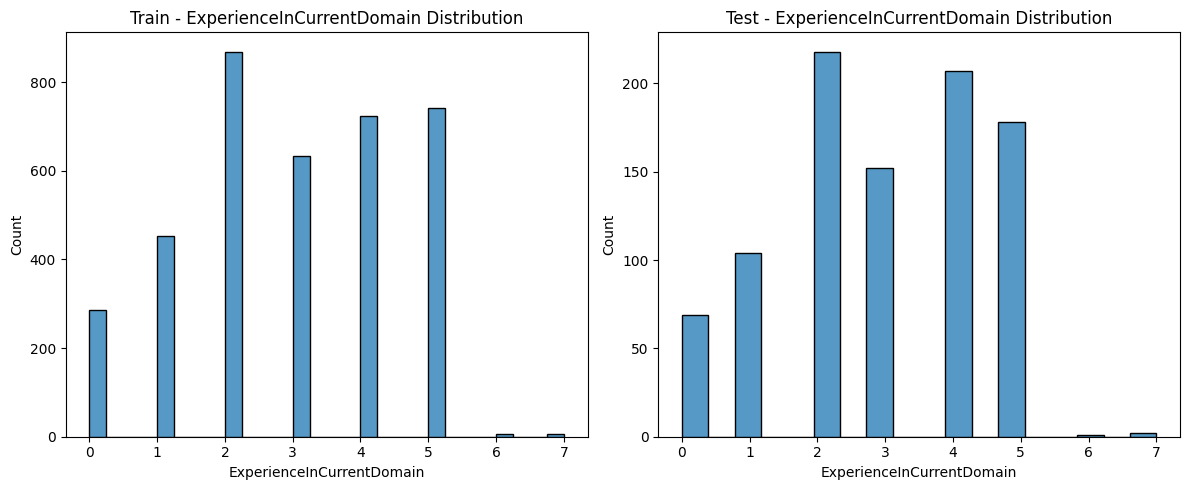

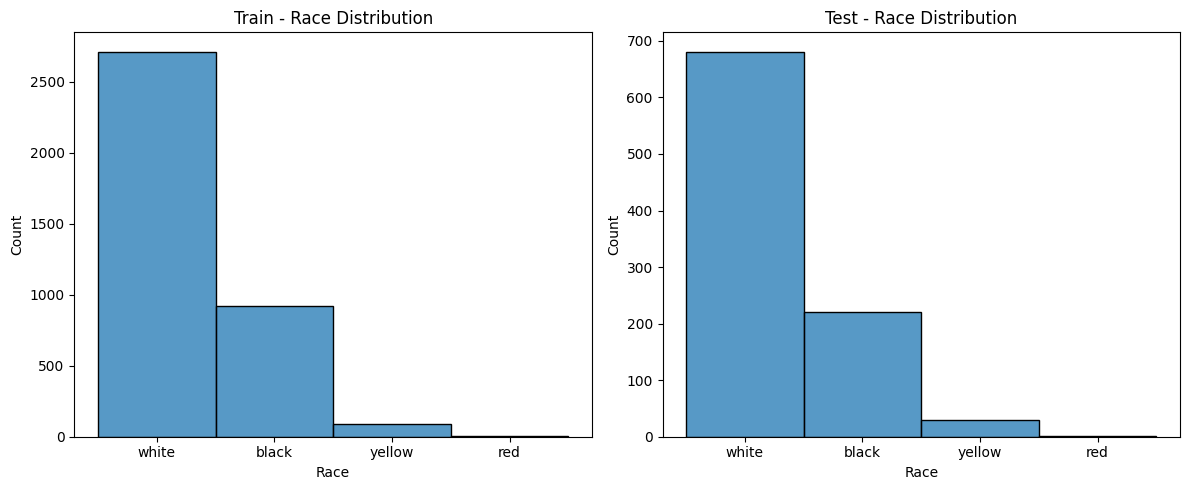

In [4]:
# Define the features for EDA (excluding 'id')
features = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age',
            'Gender', 'EverBenched', 'ExperienceInCurrentDomain', 'Race']

# Plotting histograms for each feature
for feature in features:
    plt.figure(figsize=(12, 5))

    # Plot for Train dataset
    plt.subplot(1, 2, 1)
    sns.histplot(X_train[feature])#, kde=True)
    plt.title(f'Train - {feature} Distribution')

    # Plot for Test dataset
    plt.subplot(1, 2, 2)
    sns.histplot(X_test[feature])#, kde=True)
    plt.title(f'Test - {feature} Distribution')

    plt.tight_layout()
    plt.show()


##Preprocess Pipeline
Currently it is without lines removal due to the fact the y_train must be aligned to X_train_cleaned.

Lines with missing data will be handled externally, while aligining between X_train and y_train

###The Pipline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Custom transformer for creating the Tenure feature
class TenureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['Tenure'] = 2023 - X['JoiningYear']
        return X[['Tenure']]

# Custom transformer to capture indices (in order to align y_train to preprocessed X_train)
class IndexKeeper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.indices_ = X.index  # Capture the indices
        return X

# Custom transformer for removing rows with missing data
class MissingDataRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.dropna()

class CustomMissingDataRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.retained_indices_ = None

    def fit(self, X, y=None):
        # Assuming missing values are handled here
        self.retained_indices_ = X.dropna().index
        return self

    def transform(self, X):
        return X.dropna()

# Define the columns
categorical_features = ['Education', 'City', 'Gender', 'EverBenched', 'Race']
ordinal_features = ['PaymentTier']
numerical_features = ['Age', 'ExperienceInCurrentDomain']

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[[1, 2, 3]])
numerical_transformer = StandardScaler()

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('num', numerical_transformer, numerical_features),
        ('tenure', TenureTransformer(), ['JoiningYear'])
    ],
    remainder='drop',  # Drops other columns not specified in transformers
    sparse_threshold = 0

)
# preprocessor.set_output(transform="pandas")



# Create the full pipeline
preprocessing_pipeline = Pipeline(steps=[
    # ('custom_missing_data_remover', CustomMissingDataRemover()),
    # ('index_keeper', IndexKeeper()),
    # ('remove_missing', MissingDataRemover()),
    ('preprocessor', preprocessor)
])

###Remove lines with Missing Data

In [7]:
# Identify rows with missing data in X_train
rows_with_missing_data = X_train.isnull().any(axis=1)

# Remove these rows from both X_train and y_train
X_train_cleaned = X_train[~rows_with_missing_data]
y_train_cleaned = y_train[~rows_with_missing_data]

In [8]:
X_train_cleaned.tail()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
Unnamed: 0,,,,,,,,,,
3335,Bachelors,2016,Bangalore,3,38.0,Female,No,0,3335,white
1099,Masters,2017,Pune,2,29.0,Male,No,5,1099,white
2514,Bachelors,2016,Pune,3,31.0,Male,No,5,2514,black
3606,Bachelors,2013,Pune,2,36.0,Female,No,3,3606,black
2575,Bachelors,2013,Bangalore,3,31.0,Male,No,2,2575,white


In [9]:
y_train_cleaned.tail()

,LeaveOrNot
Unnamed: 0,
3335,0
1099,1
2514,0
3606,1
2575,0


####Present rows with missing data in X_train

In [10]:
missing_data_rows = X_train.loc[rows_with_missing_data]
missing_data_rows

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
Unnamed: 0,,,,,,,,,,
0,Bachelors,2017,Bangalore,3,NaN,NaN,No,0,0,white
1,Bachelors,2013,Pune,1,NaN,NaN,No,3,1,white


In [11]:
# Remove these rows from both X_train and y_train
X_train_cleaned = X_train[~rows_with_missing_data]
y_train_cleaned = y_train[~rows_with_missing_data]

###Apply Preprocess Pipline on X_train_cleaned

In [12]:
# Fit the pipeline to X_train
X_train_processed = preprocessing_pipeline.fit_transform(X_train_cleaned)

***bold text***###Examine X_train after Preprocessing

In [13]:
# Construct feature names
categorical_features = ['Education', 'City', 'Gender', 'EverBenched', 'Race']
one_hot_features = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
ordinal_features = ['PaymentTier']
standard_scaled_features = ['Age', 'ExperienceInCurrentDomain']
custom_features = ['Tenure']

# Combine all feature names
all_feature_names = list(one_hot_features) + ordinal_features + standard_scaled_features + custom_features

# Convert the processed data to a DataFrame with feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)



In [14]:
one_hot_features

array(['Education_Bachelors', 'Education_Masters', 'Education_PHD',
       'City_Bangalore', 'City_New Delhi', 'City_Pune', 'Gender_Female',
       'Gender_Male', 'EverBenched_No', 'EverBenched_Yes', 'Race_black',
       'Race_red', 'Race_white', 'Race_yellow'], dtype=object)

In [15]:
X_train_processed_df.describe()

,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,Race_black,Race_red,Race_white,Race_yellow,PaymentTier,Age,ExperienceInCurrentDomain,Tenure
count,3720.000000,3720.00000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3.720000e+03,3.720000e+03,3720.000000
mean,0.773387,0.18871,0.037903,0.477957,0.247312,0.274731,0.403763,0.596237,0.895968,0.104032,0.246774,0.001075,0.728495,0.023656,1.696774,-1.614002e-16,1.308392e-16,7.924462
std,0.418696,0.39133,0.190988,0.499581,0.431508,0.446439,0.490717,0.490717,0.305343,0.305343,0.431192,0.032778,0.444796,0.151995,0.558000,1.000134e+00,1.000134e+00,1.864874
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.631329e+00,-1.855879e+00,5.000000
25%,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-8.083360e-01,-5.753691e-01,6.000000
50%,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,-3.968396e-01,6.488608e-02,8.000000
75%,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,6.319014e-01,7.051413e-01,9.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.483635e+00,2.625907e+00,11.000000


## Get feature importance: feature_importances_dict

In [16]:
def get_feature_importance_dict(obj,X_train):
  if(isinstance(obj, DecisionTreeClassifier)):
    feature_importance_dict = dict(zip(X_train.columns,obj.feature_importances_))
  elif (isinstance(obj, DecisionTreeClassifier)):
    print('kuku')
  # print(isinstance(lr_classifier, LogisticRegression))  # Output: True
  else:
    print ('get_feature_importance_dic: object is not supported')
  feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))
  return feature_importance_dict

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_processed_df, y_train_cleaned, test_size=0.2, random_state=42)

algo_dic = {}
algo_dic.update({'dt':{'obj':DecisionTreeClassifier()}})

for algo_name in algo_dic:
  algo_dic[algo_name]['obj'].fit(X_train, np.ravel(y_train))


algo_dic['dt']['obj'].feature_importances_

feature_importances_dict = get_feature_importance_dict(algo_dic['dt']['obj'],X_train)
for field in feature_importances_dict.keys():
  print(f'{field}:{feature_importances_dict[field]}')

Tenure:0.3059372014697085
Age:0.17102810999871468
PaymentTier:0.14791368969642124
ExperienceInCurrentDomain:0.09478321694393531
Education_Masters:0.06321112094233146
City_Pune:0.05297216906719947
Gender_Male:0.027109944039252147
Race_white:0.024809906572397233
Education_Bachelors:0.019380550530854107
Gender_Female:0.01921308518743641
City_Bangalore:0.0189303579181445
Race_black:0.016967649251811955
EverBenched_No:0.013536834964053324
City_New Delhi:0.011729261649418087
EverBenched_Yes:0.006757113244922543
Race_yellow:0.003871653133303199
Education_PHD:0.0018481353900957596
Race_red:0.0


## 1'st glance at algorithms


### Define a function to evaluate models

In [18]:
def evaluate_model(y_test,y_pred):
    dict = {}
    dict['accuracy'] = round(accuracy_score(y_test, y_pred)*100)/100
    dict['precision'] = round(precision_score(y_test, y_pred)*100)/100
    dict['recall'] = round(recall_score(y_test, y_pred)*100)/100
    dict['f1'] = round(f1_score(y_test, y_pred)*100)/100
    return dict


### Run the models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_processed_df, y_train_cleaned, test_size=0.2, random_state=42)

algo_dic = {}
algo_dic.update({'decision_tree':{'obj':DecisionTreeClassifier()}})
algo_dic.update({'random_forest':{'obj':RandomForestClassifier()}})
algo_dic.update({'logistic_regression':{'obj':LogisticRegression()}})
algo_dic.update({'gradient_boosting':{'obj':GradientBoostingClassifier()}})
algo_dic.update({'k_neighbors':{'obj':KNeighborsClassifier()}})
algo_dic.update({'ada_boost':{'obj':AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)}})




for algo_name in algo_dic:
  algo_dic[algo_name]['obj'].fit(X_train, np.ravel(y_train))
  y_pred = algo_dic[algo_name]['obj'].predict(X_test)
  eval_dict = {'name':algo_name}
  eval_dict.update(evaluate_model(y_test,y_pred))
  print(eval_dict)

{'name': 'decision_tree', 'accuracy': 0.79, 'precision': 0.74, 'recall': 0.69, 'f1': 0.71}
{'name': 'random_forest', 'accuracy': 0.81, 'precision': 0.8, 'recall': 0.67, 'f1': 0.73}
{'name': 'logistic_regression', 'accuracy': 0.73, 'precision': 0.73, 'recall': 0.42, 'f1': 0.54}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'name': 'gradient_boosting', 'accuracy': 0.85, 'precision': 0.89, 'recall': 0.68, 'f1': 0.77}
{'name': 'k_neighbors', 'accuracy': 0.81, 'precision': 0.81, 'recall': 0.64, 'f1': 0.72}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'name': 'ada_boost', 'accuracy': 0.79, 'precision': 0.75, 'recall': 0.67, 'f1': 0.71}


In [20]:
algo_dic['random_forest']['obj'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#Models Tweaking

In [21]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

##Generic Report

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

def report(clf, X, y):
    acc = accuracy_score(y_true=y,
                         y_pred=clf.predict(X))

    print("\n\n=== Confusion matrix  ===\n")
    cm = pd.DataFrame(confusion_matrix(y_true=y,
                                       y_pred=clf.predict(X)),
                      index=clf.classes_,
                      columns=clf.classes_)
    print(cm)
    print("\n\n=== Classification report  ===\n")
    rep = classification_report(y_true=y,
                                y_pred=clf.predict(X))
    print(rep)

##Hyperparameters

### Prepare parameters dictionaries

In [34]:
algo_dic = {}
algo_dic.update({'decision_tree':{'obj':DecisionTreeClassifier(),'params_dict':{}}})
algo_dic.update({'random_forest':{'obj':RandomForestClassifier(),'params_dict':{}}})
algo_dic.update({'logistic_regression':{'obj':LogisticRegression(),'params_dict':{}}})
algo_dic.update({'gradient_boosting':{'obj':GradientBoostingClassifier(),'params_dict':{}}})
algo_dic.update({'k_neighbors':{'obj':KNeighborsClassifier(),'params_dict':{}}})
algo_dic.update({'ada_boost':{'obj':AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),'params_dict':{}}})




# random_forest
algo_dic['random_forest']['params_dict'] = {
  'clf__min_samples_leaf': range(1, 2),
  'clf__min_samples_split': range(2, 3),
  'clf__n_estimators': [100,500,1000]
  }

algo_dic['gradient_boosting']['params_dict'] = {
  'clf__min_samples_leaf': range(1, 2),
  'clf__min_samples_split': range(2, 3),
  'clf__n_estimators': [100,500,1000],
  'clf__subsample': [0.5,0.75,1.0]
  }


### run greed search on selected algorithms

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel





N_features = 20
algo_names = ['random_forest','gradient_boosting']

for N_features in range (20,21):
  # create a partial X_train_model based on N_features most important features
  feature_names_importance_sorted = list(feature_importances_dict.keys())
  feature_names_model = feature_names_importance_sorted[:N_features]
  X_train_model = X_train[feature_names_model]
  X_test_model = X_test[feature_names_model]


  for algo_name in algo_names:

    # set the pipe line
    pipe_line = ImbPipeline([
        # ('preprocessing', preprocessing_pipeline),  # Replace with your preprocessing pipeline
        # ('feature_selection', SelectFromModel(DecisionTreeClassifier())),
        ('clf', algo_dic[algo_name]['obj'])
    ])

    # scores = cross_val_score(pipe_line, X_train, y_train, cv=2, scoring = 'f1')
    grid_search = GridSearchCV(pipe_line, algo_dic[algo_name]['params_dict'], cv=2,refit='f1',scoring=['recall','precision','f1'], n_jobs=-1)#, error_score='raise', verbose=3)
    scores = grid_search.fit(X_train_model, y_train.values.ravel())

    algo_dic[algo_name]['best_params'] = grid_search.best_params_
    algo_dic[algo_name]['best_estimator'] = grid_search.best_estimator_
    algo_dic[algo_name]['best_train_score'] = grid_search.best_score_

# apply best estimator on X_test
    y_pred = grid_search.best_estimator_.predict(y_test)

# evaluate test prediction
    algo_dic[algo_name]['test_scores'] = evaluate_model(y_test,y_pred)

    print(f'N={N_features},algo_name={algo_name}:{grid_search.best_score_ }')
  # log_reg_cv_scores = cross_val_score(grid_search_log_reg.best_estimator_, X_train, y_train.values.ravel(), cv=5, scoring='f1')
  # log_reg_cv_scores.mean()

# transform results to a data frame for better visualization
algo_df = pd.DataFrame(algo_dic)
algo_df[algo_names]



ValueError: ignored

In [71]:
y_pred = grid_search.best_estimator_.predict(X_test_model)
eval_dict = evaluate_model(y_test,y_pred)
algo_dic[algo_name]['test_scores'] = eval_dict
algo_dic[algo_name]['test_scores']

{'accuracy': 0.81, 'precision': 0.78, 'recall': 0.67, 'f1': 0.72}